# Dreamclinic Client Churn

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy


In [6]:
pep8 = "0987654321" * 8

In [7]:
pep8

'09876543210987654321098765432109876543210987654321098765432109876543210987654321'

In [10]:
client_df = pd.read_excel("~/dales_work/clinic_services_8-1-2016_to_8-3-2019.xlsx")


In [15]:
client_df.drop('Name_Full', axis=1, inplace=True)

In [26]:
client_df.tail()

,TransactionDate,clientID,Therapist,Address_City,Address_State,Address_Zip,Invoice_Category,Service_Category,HrsWorked
120492,2019-08-04,28219.0,Corey Bedard,Madison,WI,53711,Clinic_CA,NaN,1.0
120493,2019-08-04,77402.0,Edward Kim,Seattle,WA,98103,Clinic_Ins,NaN,1.5
120494,2019-08-04,77402.0,Edward Kim,Seattle,WA,98103,Clinic_CA,NaN,0.0
120495,2019-08-04,83106.0,Zachary Tuthill,Redmond,WA,98053,Clinic_Ins,NaN,1.0
120496,2019-08-04,54788.0,Renee Hudon,Bellevue,WA,98004,Clinic_Ins,NaN,1.0


In [29]:
# remove rows where HrsWorked = 0 because they are just used by the front desk staff
client_df  = client_df[client_df['HrsWorked'] != 0]

In [39]:
client_df['Service_Category'].fillna(value='Massage', inplace=True)

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [46]:
# remove white space from Therapist names
client_df['Therapist'] = client_df['Therapist'].str.strip()

# make all therapist names lowercase to avoid typos in data entry
client_df['Therapist'] = client_df['Therapist'].str.lower()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
# make all therapist names lowercase to avoid typos in data entry
client_df['Therapist'] = client_df['Therapist'].str.lower()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [81]:
client_df = client_df.replace('abby thomson', 'abigail thomson')

In [65]:
# def name_replace(df, nickname, realname):
#     """Replaces nicknames with realnames for therapists in DataFrame"""
#     df = df.replace(nickname, realname)
#     return client_df

In [83]:
client_df.shape

(113080, 9)

In [84]:
client_df.head(10)

,TransactionDate,clientID,Therapist,Address_City,Address_State,Address_Zip,Invoice_Category,Service_Category,HrsWorked
0,2016-08-02,40156.0,michael jacobus,Seattle,Wa,98109,Clinic_Ins,Massage,1.0
1,2016-08-02,60005.0,lauren anderson,seattle,wa,98119,Clinic_CA,Massage,1.0
2,2016-08-02,43420.0,stefanie smith,Seattle,WA,98144,Clinic_Ins,Massage,1.0
3,2016-08-02,56100.0,elizabeth panelo,Seattle,Wa,98203,Clinic_Ins,Massage,1.0
4,2016-08-02,57367.0,daniel cook,Seattle,WA,98115,Clinic_Ins,Massage,1.0
5,2016-08-02,33090.0,erin burgman,Omaha,NE,68104,Clinic_Ins,Massage,1.0
6,2016-08-02,42653.0,charles lewis,Mountlake Terrace,WA,98043,Clinic_Ins,Massage,1.0
7,2016-08-02,32225.0,haakon latvala,Seattle,WA,98115,Clinic_Ins,Massage,1.0
8,2016-08-02,6637.0,jessica kelly,Lake Forest Park,WA,98155,Clinic_Ins,Massage,1.0
9,2016-08-02,43857.0,michael jacobus,Seattle,WA,98109,Clinic_CA,Massage,1.0


In [91]:
client_df['Year'] = client_df['TransactionDate'].map(lambda x: x.year)

In [92]:
client_df['Month'] = client_df['TransactionDate'].map(lambda x: x.month)

In [94]:
client_df.drop('Year_Month', axis=1, inplace=True)

In [96]:
client_df.tail()

,TransactionDate,clientID,Therapist,Address_City,Address_State,Address_Zip,Invoice_Category,Service_Category,HrsWorked,Year,Month
120491,2019-08-04,83461.0,ty green,NaN,NaN,NaN,Clinic_CA,Massage,1.0,2019,8
120492,2019-08-04,28219.0,corey bedard,Madison,WI,53711,Clinic_CA,Massage,1.0,2019,8
120493,2019-08-04,77402.0,edward kim,Seattle,WA,98103,Clinic_Ins,Massage,1.5,2019,8
120495,2019-08-04,83106.0,zachary tuthill,Redmond,WA,98053,Clinic_Ins,Massage,1.0,2019,8
120496,2019-08-04,54788.0,renee hudon,Bellevue,WA,98004,Clinic_Ins,Massage,1.0,2019,8


In [110]:
counts_by_month = client_df.groupby(['Year', 'Month']).nunique()

In [106]:
client_df.drop(['Address_City', 'Address_State'], axis=1, inplace=True)

In [111]:
counts_by_month

TransactionDate  clientID  Therapist  Address_Zip  \
Year Month                                                      
2016 8                   30      1651         59          163   
     9                   30      1670         55          166   
     10                  31      1670         54          153   
     11                  29      1604         56          158   
     12                  30      1664         57          155   
2017 1                   30      1792         62          143   
     2                   28      1760         68          138   
     3                   31      1941         70          160   
     4                   30      2004         67          172   
     5                   31      1969         60          172   
     6                   30      1913         67          179   
     7                   30      1967         67          189   
     8                   31      2037         65          188   
     9                   30      2005         66          181   
     10                  31      2032         75          167   
     11                  29      2102         73          153   
     12                  30      2128         74          181   
2018 1                   30      2218         79          177   
     2                   28      2196         76          176   
     3                   31      2326         79          190   
     4                   30      2233         76          165   
     5                   31      2217         74          169   
     6                   30      2156         75          177   
     7                   30      2068         73          192   
     8                   31      2221         73          192   
     9                   30      2119         72          183   
     10                  31      2205         77          190   
     11                  29      2112         81          169   
     12                  30      2021         74          163   
2019 1                   30      2141         74          171   
     2                   27      1827         73          150   
     3                   31      2195         71          168   
     4                   30      2089         71          164   
     5                   31      2121         74          181   
     6                   30      2178         75          197   
     7                   30      2136         80          205   
     8                    4       306         58           59   

            Invoice_Category  Service_Category  HrsWorked  Year  Month  
Year Month                                                              
2016 8                     2                 6          6     1      1  
     9                     2                 5          6     1      1  
     10                    2                 5          7     1      1  
     11                    2                 6          7     1      1  
     12                    2                 5         10     1      1  
2017 1                     2                 6          7     1      1  
     2                     2                 8          8     1      1  
     3                     2                 6         10     1      1  
     4                     2                 5          9     1      1  
     5                     2                 6          9     1      1  
     6                     2                 6         12     1      1  
     7                     2                 6         12     1      1  
     8                     2                 5         10     1      1  
     9                     2                 5         10     1      1  
     10                    2                 5         11     1      1  
     11                    2                 6          7     1      1  
     12                    2                 6          7     1      1  
2018 1                     2                 7          8     1      1  
     2          

In [ ]:
per = client_df.TransactionDate.dt.to_period("M")  # new way to get the same

In [ ]:
g = client_df.groupby(per)

In [122]:
client_count_df = g.nunique()  #

In [128]:
client_count_df.drop('TransactionDate', axis=1, inplace= True)

In [133]:
client_count_df.reset_index(inplace=True)

In [179]:
client_count_df["client_count"] = client_count_df['clientID']

In [182]:
client_count_df.drop('clientID', axis=1, inplace=True)

In [140]:
client_count_df['TransactionDate'] = client_count_df['TransactionDate'].astype('str')

# Graph of unique client counts per month from August, 2016

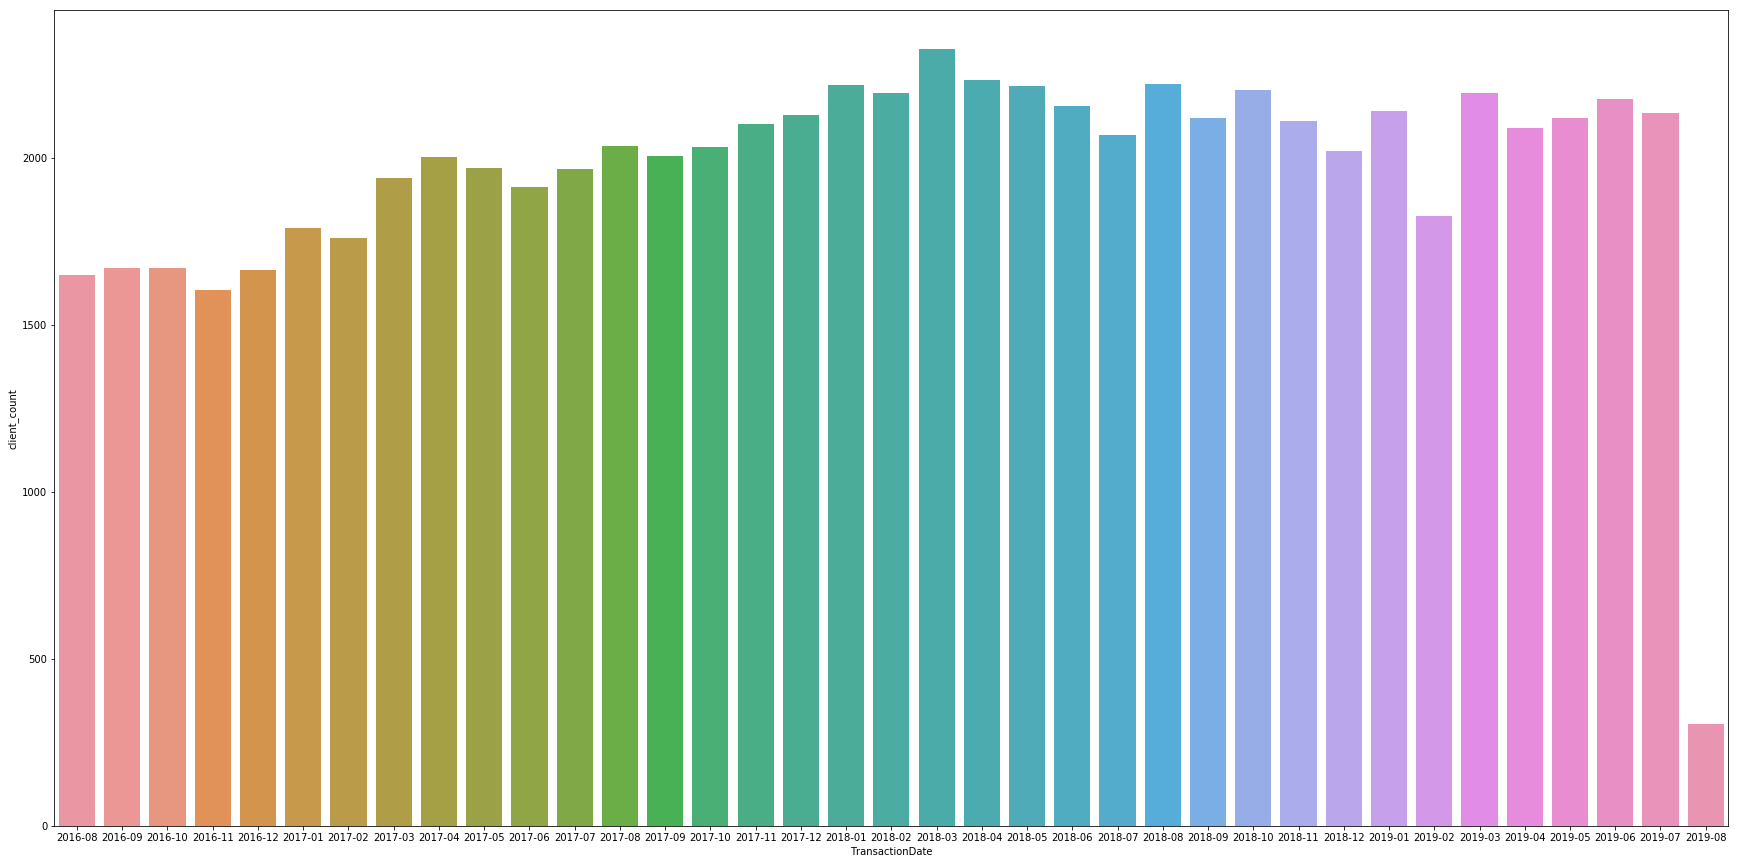

In [196]:
x = client_count_df['TransactionDate']
y = client_count_df['client_count']


fig, ax = plt.subplots(figsize=(30,15))
sns.barplot(x= client_count_df['TransactionDate'], 
             y= client_count_df['client_count'],
             ax=ax);


In [184]:
service_given_df = g.count()

In [190]:
service_given_df.drop(['TransactionDate', 'Address_Zip'], axis=1, inplace=True)

In [193]:
service_given_df['services_performed'] = service_given_df['clientID']

In [194]:
service_given_df.drop('clientID', axis=1, inplace=True)

In [197]:
service_given_df.reset_index(inplace=True)

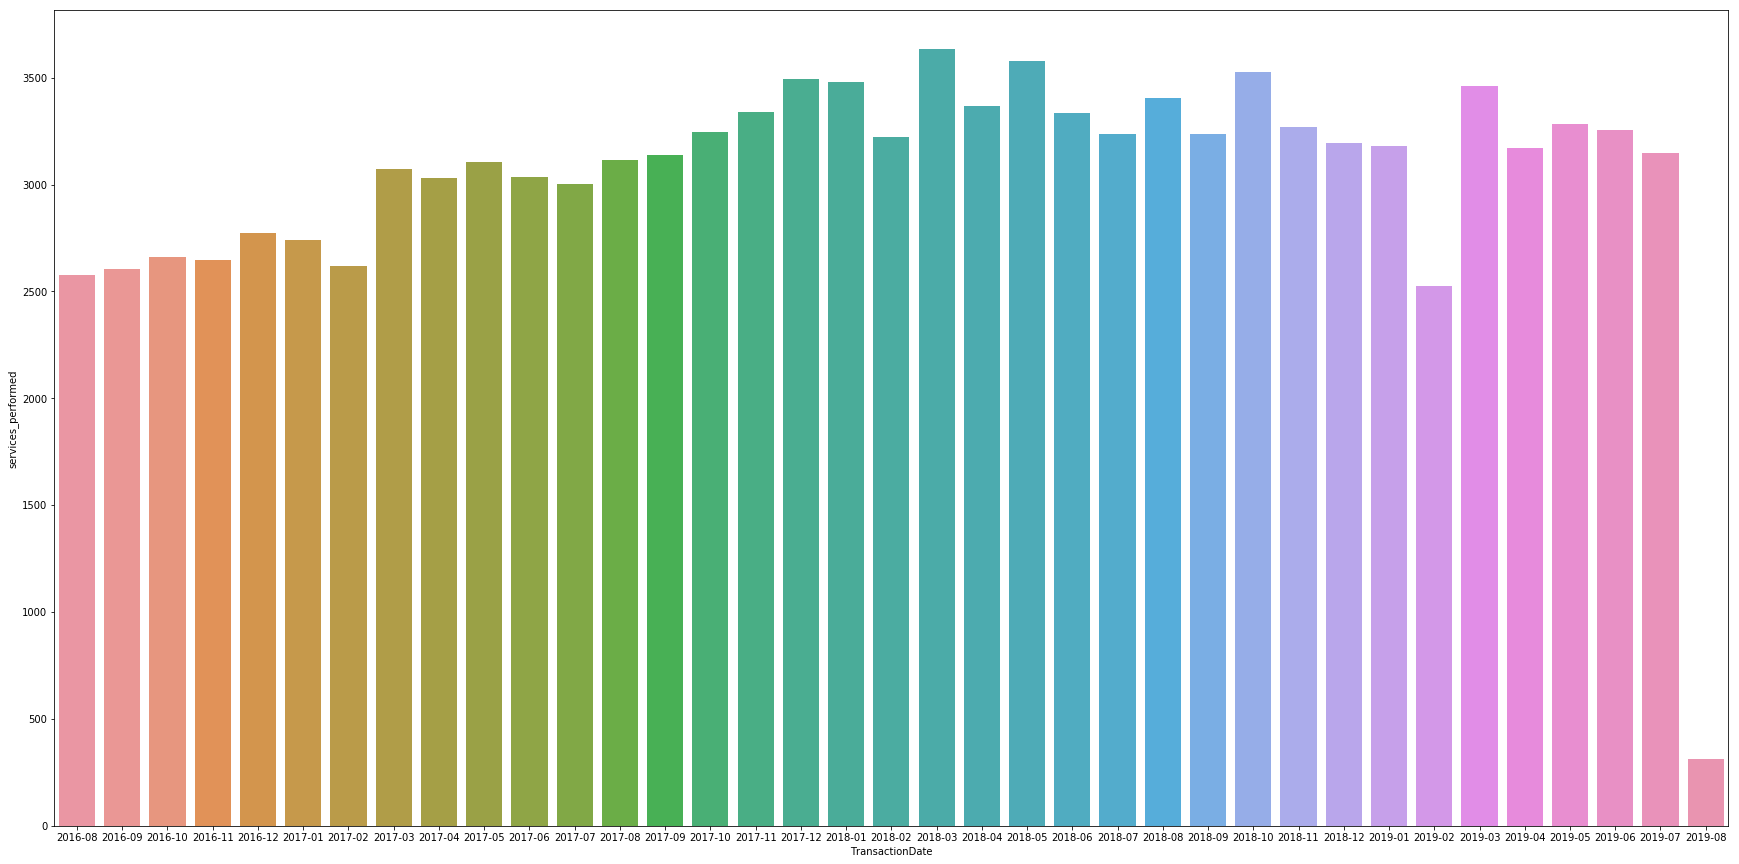

In [199]:
x = service_given_df['TransactionDate']
y = service_given_df['services_performed']


fig, ax = plt.subplots(figsize=(30,15))
sns.barplot(x= service_given_df['TransactionDate'], 
             y= service_given_df['services_performed'],
             ax=ax);